<center><h1><b><u> Multilayer Perceptron for MNIST Dataset From Scratch</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [1]:
import numpy as np
from operator import itemgetter
import random
import json
import pickle
import matplotlib.pyplot as plt
from PIL import Image

## __Loading the Data__

In [2]:
def extract_images(filename):
    '''Many file formats use magic numbers so that file readers can easily identify them to verify its reading correct file type. This prevents some errors. Each
    pixel is represented from value 0-255 (an unsigned byte/8 bit integer). Metadata is big endian (>, normal) and 4 byte/32 bit integer and stored as 1D array.
    file.read(x) takes x bytes from the file and creates an immutable buffer (a bytes object, an array of bytes) and stores it in memory. frombuffer interprets buffer object as array
    of bytes of certain data type. It doesn't copy the data just provides a view of the existing data and converts to numpy array.'''
    with open(filename, 'rb') as f: #read binary
        buffer = f.read(16) #metadata
        magic, num_images, rows, cols = np.frombuffer(buffer, dtype='>i4') #rows and columns per image (dimensions)
        data = np.frombuffer(f.read(), dtype=np.uint8) #read and store remaining data in 1D numpy array; #numpy spaces out elements instead of commas
        data = data.reshape(num_images, rows, cols).astype(np.float32) #reshape flat data into 3D, num_image amt of rows x cols arrays
    return data

def extract_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = np.frombuffer(f.read(8), dtype='>i4')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels] #certain row of the identity matrix

def load_mnist():
    data_path = '../data/MNIST/raw'
    train_images = extract_images(f'{data_path}/train-images-idx3-ubyte')
    train_labels = extract_labels(f'{data_path}/train-labels-idx1-ubyte')
    test_images = extract_images(f'{data_path}/t10k-images-idx3-ubyte')
    test_labels = extract_labels(f'{data_path}/t10k-labels-idx1-ubyte')

    #Make sure data is right shape for forward pass
    train_images_flat = train_images.reshape(60000, 784).T
    test_images_flat = test_images.reshape(10000, 784).T

    train_labels_one_hot = one_hot_encode(train_labels).T
    test_labels_one_hot = one_hot_encode(test_labels).T
    
    return (train_images_flat, train_labels_one_hot), (test_images_flat, test_labels_one_hot) #each dataset is tuple of numpy arrays

In [3]:
#Comma means tuple containing 1 element otherwise would just be int; numpy arrays come with useful attributes like shape
(train_images, train_labels), (test_images, test_labels) = load_mnist()

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (784, 60000)
Train labels shape: (10, 60000)
Test images shape: (784, 10000)
Test labels shape: (10, 10000)


### __Viewing a Sample__

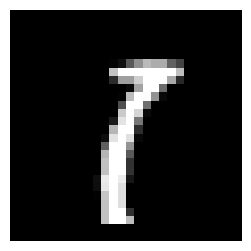

In [4]:
index = random.randrange(0, train_images.shape[1])

plt.figure(figsize=(6, 3))
plt.imshow(train_images[:, index].reshape(28,28), cmap = 'gray')
plt.axis("off")
plt.show()

## __Initializing the Hyperparameters__

In [5]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
        self.lr = hyper_dict['learning_rate']
        self.b_size = hyper_dict['batch_size']
        self.n_slope = hyper_dict['n_slope']
        self.epochs = hyper_dict['epochs']
        self.hidden = hyper_dict['hidden']
        self.augment = hyper_dict['augment']
        self.prob_augment = hyper_dict['prob_augment']
        self.degrees = hyper_dict['degrees']
        self.trans_horz = hyper_dict['trans_horz']
        self.trans_vert = hyper_dict['trans_vert']
        self.scale_min = hyper_dict['scale_min']
        self.scale_max = hyper_dict['scale_max']
        self.shear = hyper_dict['shear']
        self.brightness = hyper_dict['brightness']
        self.contrast = hyper_dict['contrast']


#can feed this into functions that need hypers
hypers = Hypers('../config/mlp-scratch-hyperparameters.json')

### __Defining Functions for Scalars/Vectors/Matrices__

In [6]:
def softmax(x): #x is vector
    # Subtract max for numerical stability, keeping dims for proper broadcasting
    x_shifted = x - np.max(x, axis=0, keepdims=True)
    
    # Compute exponentials
    exp_x = np.exp(x_shifted)
    
    # Compute softmax
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [7]:
def relu(z):
    return np.maximum(z, 0)

In [8]:
def drelu_dz(z):
    return np.where(z <= 0, 0.0, 1.0).astype(np.float32)

In [9]:
train_dataset = norm_transform(train_dataset)
test_dataset = norm_transform(test_dataset)

## __Analyzing the Data__

In [10]:
def distribution(dataset):
    freq = {}

    for image, label in dataset:
        freq[label] = freq.get(label, 0) + 1

    #list of tuples
    freq_sorted = sorted(freq.items(), key = itemgetter(1), reverse = True)
    for number, freq in freq_sorted:
        print(f'{number}: {freq}')

In [11]:
distribution(train_dataset)

1: 6742
7: 6265
3: 6131
2: 5958
9: 5949
0: 5923
6: 5918
8: 5851
4: 5842
5: 5421


### __Defining Functions__

In [36]:
def softmax(x): #x is vector
    x_shifted = x - np.max(x) #ensures exp(x) is in range [0,1]
    
    sum_exp = np.sum(np.exp(x_shifted))

    #np operations create new objects
    return np.exp(x_shifted) / sum_exp

In [48]:
def cross_entropy(y_truth, y_pred): 

    #Replace 0 predicted prob with small value to avoid log(0)
    epsilon = 1e-15
    y_pred = np.maximum(y_pred, epsilon)
    
    return -np.sum(y_truth * np.log(y_pred))

In [67]:
def relu(z):
    return 0 if z <=0 else z

In [68]:
def he_init(shape):
    #input, hidden
    fan_in, fan_out = shape
    
    #scaling factor; 2 for ReLU
    scaling = np.sqrt(2/fan_in)

    #create matrix sampled from Gaussian and multiply by scaling factor
    return np.random.randn(fan_in, fan_out) * scaling

In [69]:
class MultiLayerPerceptron:
    def __init__(self, batch_size = 64, input_dim = 784, hidden_dim = 1024, output = 10):
        W = he_init((input_dim, hidden_dim)) 
        X = np.zeros(input_dim, batch_size)


    #forward
    def __call__(self, batch):
        

SyntaxError: incomplete input (1735320313.py, line 9)